# Второе домашнее задание
https://docs.google.com/document/d/1E6Mvo_0CBZelxhQyHM37R3DKdgVWDEeC56SZ2A9DNIc/edit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from datetime import timedelta
from sklearn import linear_model

sns.set_style("whitegrid")
figsize = (12,6)
legend_fontsize = 14

pd.set_option('display.max_columns', 30)
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/root/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))


## Загружаем и визуализируем данные

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [3]:
data.shape

(17222, 29)

In [4]:
min_date = '2020-03-03'
max_date = data.date.max()
max_date

'2020-05-14'

In [5]:
train_days = 60

In [6]:
ru_data = data[(data.location == 'Russia') & (data.date >= min_date)].reset_index(drop=True).copy()

In [7]:
ru_data['day'] = ru_data.index

In [8]:
print(ru_data.shape)
ru_data.head()

(73, 30)


,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,day
0,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,0
1,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1
2,RUS,Russia,2020-03-05,4,0,0,0,0.027,0.000,0.0,0.0,46414.0,NaN,0.318,NaN,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,2
3,RUS,Russia,2020-03-06,4,0,0,0,0.027,0.000,0.0,0.0,51366.0,4952.0,0.352,0.034,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,3
4,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,0.0,55688.0,4322.0,0.382,0.030,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,4


In [9]:
def days_to_dates(days, min_date=min_date):
    if type(min_date) != pd.datetime:
        min_date = pd.to_datetime(min_date)
    dates = [min_date + timedelta(days=float(d)) for d in days]
    return dates

In [10]:
xtick_locator = AutoDateLocator(interval_multiples=False)
xtick_formatter = AutoDateFormatter(xtick_locator)

In [11]:
def plot_series(days, y, label, fig=None, ax=None, min_date=min_date):
    fig = fig or plt.figure(figsize=figsize)
    ax = ax or fig.add_subplot(111)
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)    
    dates = days_to_dates(days, min_date)
    ax.plot(dates, y, linewidth=2, label=label)
    ax.legend(fontsize=legend_fontsize)
    return fig, ax

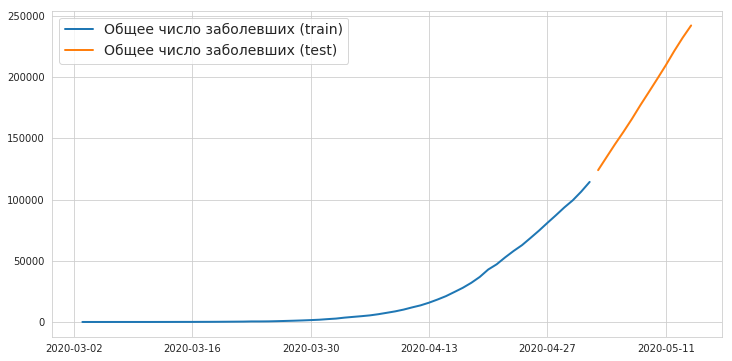

In [12]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], ru_data.total_cases.iloc[:train_days+1],
                      'Общее число заболевших (train)')
plot_series(ru_data.day.iloc[train_days+1:], ru_data.total_cases.iloc[train_days+1:],
                      'Общее число заболевших (test)', fig, ax);

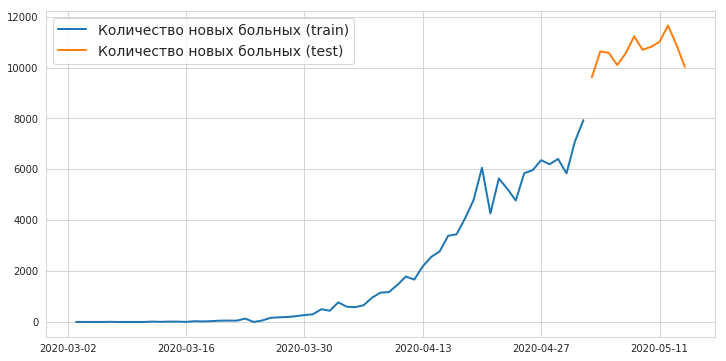

In [13]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], ru_data.new_cases.iloc[:train_days+1],
                      'Количество новых больных (train)')
plot_series(ru_data.day.iloc[train_days+1:], ru_data.new_cases.iloc[train_days+1:],
                      'Количество новых больных (test)', fig, ax);

## Модель экспоненциального роста
Будем обучать модель вида $y \sim exp(w_0 + w_1x)$, где x — номер дня, начиная с 3 марта 2020 года.  
Чтобы применить линейную регрессию, прологарифмируем целевые функции.  
При этом мы неявно делаем предположение, что в логарифмической шкале шум распределён нормально, а значит в исходной - логнормально

In [14]:
log_ru_new_cases = np.log(ru_data.new_cases + 1)
log_ru_total_cases = np.log(ru_data.total_cases)

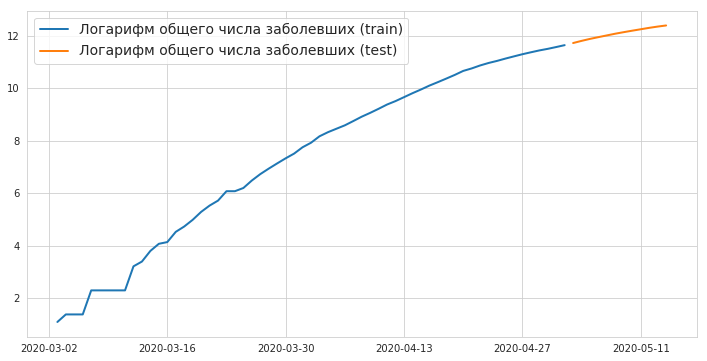

In [15]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], log_ru_total_cases.iloc[:train_days+1],
                      'Логарифм общего числа заболевших (train)')
plot_series(ru_data.day.iloc[train_days+1:], log_ru_total_cases.iloc[train_days+1:],
                      'Логарифм общего числа заболевших (test)', fig, ax);

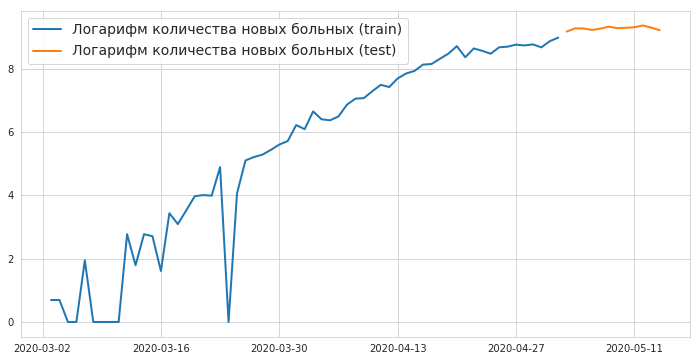

In [16]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], log_ru_new_cases.iloc[:train_days+1],
                      'Логарифм количества новых больных (train)')
plot_series(ru_data.day.iloc[train_days+1:], log_ru_new_cases.iloc[train_days+1:],
                      'Логарифм количества новых больных (test)', fig, ax);

### Для начала просто обучим модели методом максимального правдоподобия
То есть получим ML-гипотезу на параметры $w_0$ и $w_1$

In [17]:
def print_model_coefs(model=None, coefs=None):
    if model is None and coefs is None:
        raise ValueError
    coefs = coefs or [model.intercept_] + model.coef_.tolist()
    coef_labels = '[w0,w1]' if len(coefs) == 2 else f'[w0;...;w{len(coefs)-1}]'
    coefs = np.around(coefs, decimals=5)
    print(f'Коэффициенты модели {coef_labels}: {coefs}')

In [18]:
def eval_ml_model(model, x, y, label_prefix, pred_transform=None):
    pred_transform = pred_transform or (lambda x: x)
    print_model_coefs(model)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    model_pred = pred_transform(model.predict(x))
    fig, ax = plot_series(x[:train_days+1, 0], y[:train_days+1], f'{label_prefix} (train)')
    plot_series(x[train_days+1:len(y), 0], y[train_days+1:], f'{label_prefix} (test)', fig, ax)
    plot_series(x[:, 0], model_pred, f'{label_prefix} (prediction)', fig, ax)
    return fig, ax

##### Модель для новых больных

In [19]:
log_ru_new_cases_model = linear_model.LinearRegression().fit(ru_data.day.iloc[:train_days+1].values.reshape(-1, 1),
                                                             log_ru_new_cases.iloc[:train_days+1].values)

Коэффициенты модели [w0,w1]: [0.53961 0.16185]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5da6b39390>)

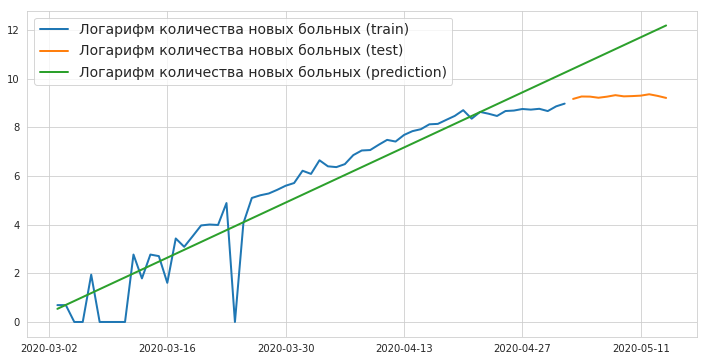

In [20]:
eval_ml_model(log_ru_new_cases_model, ru_data.day.values, log_ru_new_cases.values, 'Логарифм количества новых больных')

Коэффициенты модели [w0,w1]: [0.53961 0.16185]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5da6afe780>)

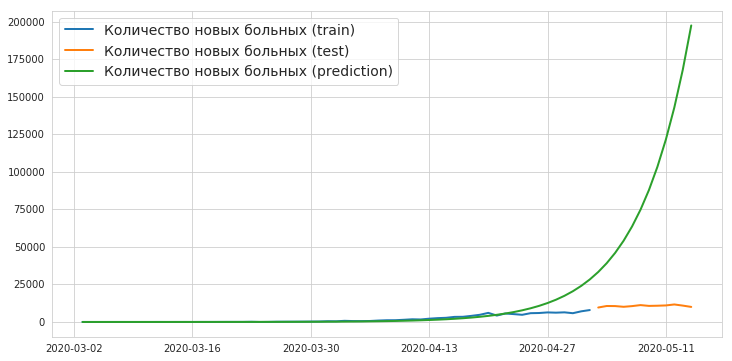

In [21]:
eval_ml_model(log_ru_new_cases_model, ru_data.day.values, ru_data.new_cases.values, 'Количество новых больных',
             pred_transform=lambda x: np.exp(x)-1)

##### Модель для общего числа больных

In [22]:
log_ru_total_cases_model = linear_model.LinearRegression().fit(ru_data.day.iloc[:train_days+1].values.reshape(-1, 1),
                                                             log_ru_total_cases.iloc[:train_days+1].values)

Коэффициенты модели [w0,w1]: [1.85363 0.18251]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5da6a782b0>)

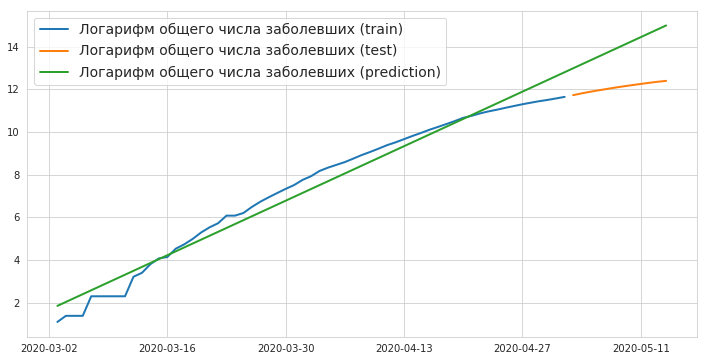

In [23]:
eval_ml_model(log_ru_total_cases_model, ru_data.day.values, log_ru_total_cases.values, 'Логарифм общего числа заболевших')

Коэффициенты модели [w0,w1]: [1.85363 0.18251]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5da43e8128>)

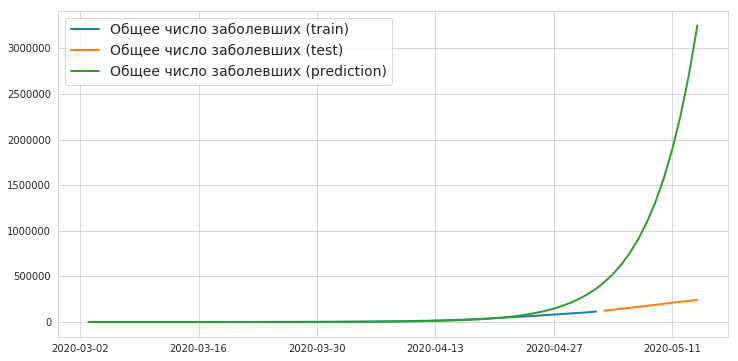

In [24]:
eval_ml_model(log_ru_total_cases_model, ru_data.day.values, ru_data.total_cases.values, 'Общее число заболевших',
             pred_transform=np.exp)

### Теперь получим апостериорное распределение параметров модели
Конечно же для начала нужно задать априорное распределение. В нашем случае удобно взять нормальное распределение.

In [25]:
from scipy.stats import multivariate_normal

def plot_heatmap(func, x_min, x_max, y_min, y_max, title=None, n_points=500):
    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(y_min, y_max, n_points)
    xs, ys = np.meshgrid(x, y)
    pos = np.empty(xs.shape + (2,))
    pos[:, :, 0] = xs
    pos[:, :, 1] = ys
    z = func(pos)
    plt.pcolormesh(xs, ys, z, cmap=plt.cm.jet)
    if title:
        plt.title(title)
    plt.show()

In [26]:
prior_mu, prior_cov = np.array([0, 0]), np.eye(2) * 3

prior_dist = multivariate_normal(mean=prior_mu, cov=prior_cov)

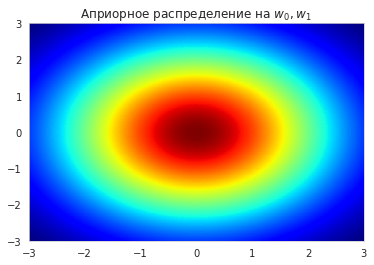

In [27]:
plot_heatmap(prior_dist.pdf, -3, 3, -3, 3, 'Априорное распределение на $w_0, w_1$')

In [28]:
def plot_pred_std(x, predictions, fig, ax):
    mean, std = np.mean(predictions, axis=0), np.std(predictions, axis=0) 
    ax.fill_between(x, mean - std, mean + std, alpha=0.5, label='Стандартное отклонение предсказаний', color='g')
    return fig, ax

In [29]:
def plot_sample_exponents(dist, x_max=20, y_max=1e5, n=50, n_params=5, plot_std=True):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)
    x_range = np.arange(1, x_max, 0.1)   
    dates = days_to_dates(x_range)
    y_values = np.empty((n, len(x_range)))
    for i, (w0, w1) in enumerate(dist.rvs(n)):
        if n_params is None or i < n_params:
            print(f'w0={w0}, w1={w1}')
        y = np.exp(w0 + w1 * x_range)
        y_values[i] = y
        ax.plot(dates, y, 'k-', lw=0.5, alpha=0.5)
    if plot_std:
        plot_pred_std(dates, y_values, fig, ax)
    plt.ylim((0, y_max))
    return fig, ax

Примеры параметров и экспонент из априорного распределения
w0=-0.35198848005095384, w1=-1.674637658991586
w0=2.90375625505267, w1=1.0121004476547752
w0=1.0562354421276374, w1=2.408163399496956
w0=0.0585758412012066, w1=-0.4459623832430632
w0=0.4820644277894103, w1=-0.43981647264317536


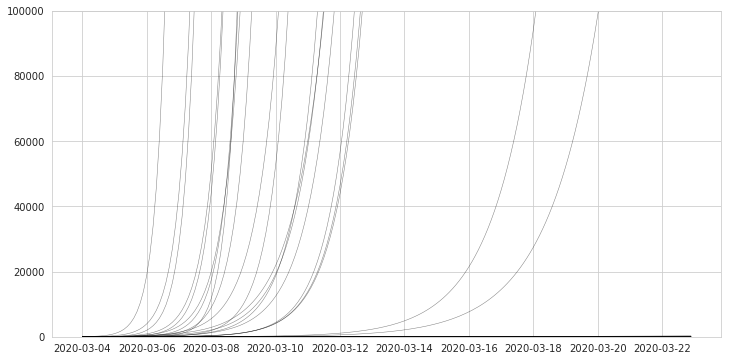

In [30]:
print('Примеры параметров и экспонент из априорного распределения')
plot_sample_exponents(prior_dist, plot_std=False);

#### Чтобы найти апостериорное распределение на параметры модели, нужно оценить дисперсию шума в данных
Используем для этого готовую Maximum-Likelihood оценку параметров

In [31]:
def get_variance(model, x, y):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    x_train = x[:train_days+1]
    y_train = y[:train_days+1]
    pred = model.predict(x_train)
    return np.var(pred - y_train)

In [32]:
ru_total_cases_variance = get_variance(log_ru_total_cases_model, ru_data.day.values, log_ru_total_cases.values)
ru_total_cases_variance

0.2812053674187978

In [33]:
ru_new_cases_variance = get_variance(log_ru_new_cases_model, ru_data.day.values, log_ru_new_cases.values)
ru_new_cases_variance

0.8350968830508231

In [34]:
from numpy.linalg import inv
    
def bayesian_update(prior_mu, prior_cov, x, y, data_variance):
    beta = 1 / data_variance
    x = np.c_[np.ones(len(x)), x]
    cov_n = inv(inv(prior_cov) + beta * x.T @ x)
    mu_n = cov_n @ (inv(prior_cov) @ prior_mu + beta * x.T @ y)
    return mu_n, cov_n

In [35]:
ru_total_cases_mu_posterior, ru_total_cases_cov_posterior = bayesian_update(prior_mu, prior_cov,
                    ru_data.day.iloc[:train_days+1].values, log_ru_total_cases.iloc[:train_days+1].values,
                    ru_total_cases_variance)

In [36]:
ru_total_cases_posterior = multivariate_normal(mean=ru_total_cases_mu_posterior, cov=ru_total_cases_cov_posterior)

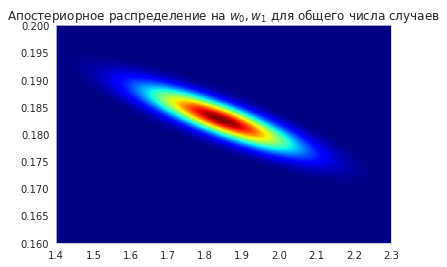

In [37]:
plot_heatmap(ru_total_cases_posterior.pdf, 1.4, 2.3, 0.16, 0.2,
             'Апостериорное распределение на $w_0, w_1$ для общего числа случаев')

Примеры параметров и экспонент из апостериорного распределения для общего числа случаев
w0=1.8469776405240077, w1=0.18053313602803117
w0=1.7764481295444088, w1=0.1876746572887433
w0=1.8188576666189293, w1=0.1819712559141737
w0=1.75464688116689, w1=0.18355025430536215
w0=1.7294808458001947, w1=0.18959852251752682


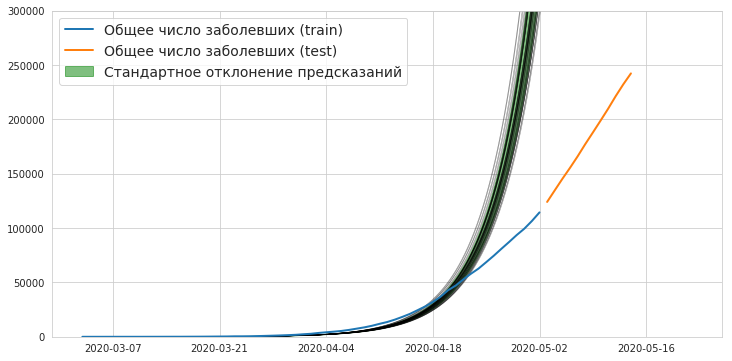

In [38]:
print('Примеры параметров и экспонент из апостериорного распределения для общего числа случаев')
fig, ax = plot_sample_exponents(ru_total_cases_posterior, x_max=80, y_max=3e5)
plot_series(ru_data.day.values[:train_days+1], ru_data.total_cases.values[:train_days+1]
            , f'Общее число заболевших (train)', fig, ax)
plot_series(ru_data.day.values[train_days+1:], ru_data.total_cases.values[train_days+1:]
            , f'Общее число заболевших (test)', fig, ax);

In [39]:
ru_new_cases_mu_posterior, ru_new_cases_cov_posterior = bayesian_update(prior_mu, prior_cov,
                    ru_data.day.iloc[:train_days+1], log_ru_new_cases.iloc[:train_days+1],
                    ru_new_cases_variance)

In [40]:
ru_new_cases_posterior = multivariate_normal(mean=ru_new_cases_mu_posterior, cov=ru_new_cases_cov_posterior)

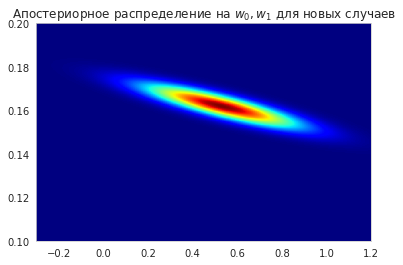

In [41]:
plot_heatmap(ru_new_cases_posterior.pdf, -0.3, 1.2, 0.1, 0.2, 'Апостериорное распределение на $w_0, w_1$ для новых случаев')

Примеры параметров и экспонент из апостериорного распределения для новых случаев
w0=0.7757943024745275, w1=0.16324146105827184
w0=0.4601061708272186, w1=0.1675622690644198
w0=0.5046746160339605, w1=0.1647802797552225
w0=0.62786961845798, w1=0.14934965915104337
w0=0.509216181600937, w1=0.16324915173107177


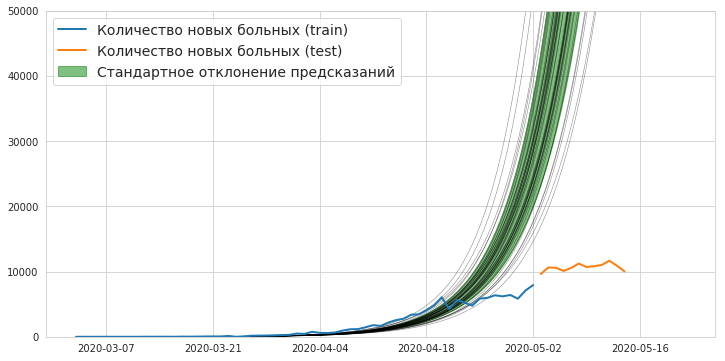

In [42]:
print('Примеры параметров и экспонент из апостериорного распределения для новых случаев')
fig, ax = plot_sample_exponents(ru_new_cases_posterior, x_max=80, y_max=5e4)
plot_series(ru_data.day.values[:train_days+1], ru_data.new_cases.values[:train_days+1],
            f'Количество новых больных (train)', fig, ax)
plot_series(ru_data.day.values[train_days+1:], ru_data.new_cases.values[train_days+1:],
            f'Количество новых больных (test)', fig, ax);

### Найдём предсказательные распределения на общее число случаев в России

In [43]:
def get_day_number(date_str):
    return (pd.to_datetime(date_str) - pd.to_datetime(min_date)).days + 1

#### К первому мая

In [44]:
date = '2020-05-01'
day = get_day_number(date)
day

60

In [45]:
def generate_predictions(distribution, day, n=10000):
    pred_values = []
    for w0, w1 in distribution.rvs(n):
        pred_value = np.exp(w0 + w1 * day)
        pred_values.append(pred_value)
    return pd.Series(pred_values)

In [46]:
def describe_predictions(pred_values, date):
    try:
        real_value = ru_data.loc[ru_data.date == date, 'total_cases'].iloc[0]
    except IndexError:
        real_value = 'N/A'
    print(f'Релаьное число заболевших к {date}: {real_value}')
    print(f'Ожидаемое (среднее по предсказаниям) число заболевших к {date}: {pred_values.mean():.0f}')
    ci_min, ci_max = pred_values.quantile(0.05), pred_values.quantile(0.95)
    print(f'90%-доверительный интервал: ({ci_min:.0f}, {ci_max:.0f})')
    print('Эмпирическое распределение:')
    pred_values.hist(density=True, bins=100);

In [47]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-05-01: 106498
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-05-01: 369961
90%-доверительный интервал: (293944, 457480)
Эмпирическое распределение:


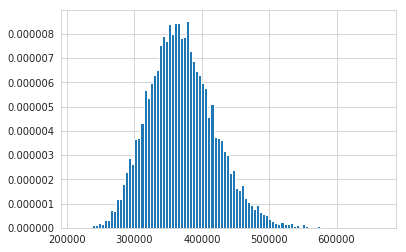

In [48]:
describe_predictions(pred_values, date)

#### К первому июня

In [49]:
date = '2020-06-01'
day = get_day_number(date)
day

91

In [50]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-06-01: N/A
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-06-01: 108597217
90%-доверительный интервал: (70605684, 157719272)
Эмпирическое распределение:


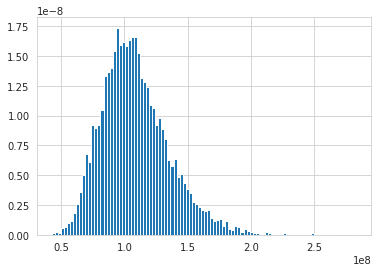

In [51]:
describe_predictions(pred_values, date)

#### К первому сентября

In [52]:
date = '2020-09-01'
day = get_day_number(date)
day

183

In [53]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-09-01: N/A
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-09-01: 2576668494143876
90%-доверительный интервал: (818680015525177, 5740044508308710)
Эмпирическое распределение:


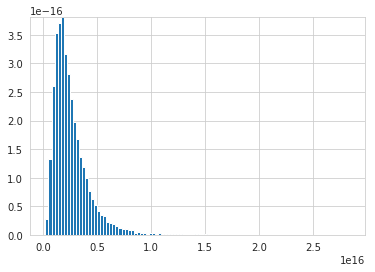

In [54]:
describe_predictions(pred_values, date)

ШОК! К сентябрю в России заболеет 2 квадриллиона людей!

## Сигмоидальная модель
Попробуем смоделировать общее число заболевших зависимостью вида
$$y \sim \int_{-\infty}^{x} exp(w_0 + w_1t + w_2t^2)dt,$$
где x — номер дня, начиная с 3 марта 2020 года.  
Чтобы обучить параметры такой модели с помощью линейной регрессии, используем два трюка. 
Во-первых заметим, что общее число заболевших в некоторый день $x$ есть сумма новых случаев заболевания за всё предыдущее время. Значит, вместо обучения непосредственно интеграла на общем числе случаев можно обучить подынтегральное выражение на новых случаях.  
Во-вторых как и в экспоненциальной модели прологарифмируем целевую функцию.

In [55]:
X = np.c_[ru_data.day, ru_data.day**2]
y = log_ru_new_cases.values

### Обучим модель методом максимального правдоподобия

In [56]:
log_poly_ru_new_cases_model = linear_model.LinearRegression().fit(X[:train_days+1], y[:train_days+1])

Коэффициенты модели [w0;...;w2]: [-0.55313  0.27298 -0.00185]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d9eedf0b8>)

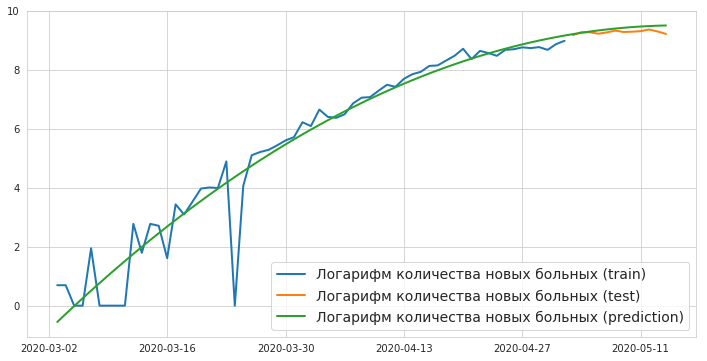

In [57]:
eval_ml_model(log_poly_ru_new_cases_model, X, log_ru_new_cases.values, 'Логарифм количества новых больных')

Коэффициенты модели [w0;...;w2]: [-0.55313  0.27298 -0.00185]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d9ef4bcf8>)

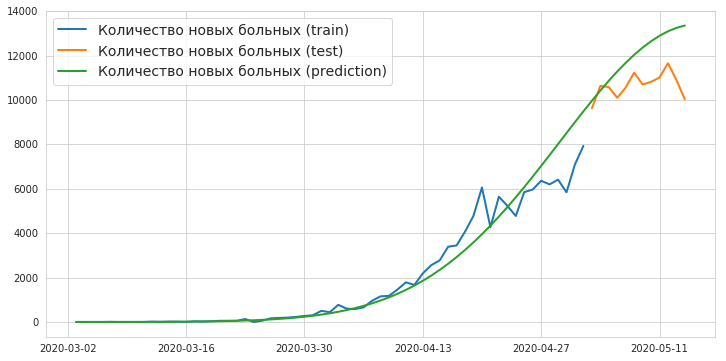

In [58]:
eval_ml_model(log_poly_ru_new_cases_model, X, ru_data.new_cases.values, 'Количество новых больных',
             pred_transform=lambda x: np.exp(x)-1)

Коэффициенты модели [w0;...;w2]: [-0.55313  0.27298 -0.00185]


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5da14a56a0>)

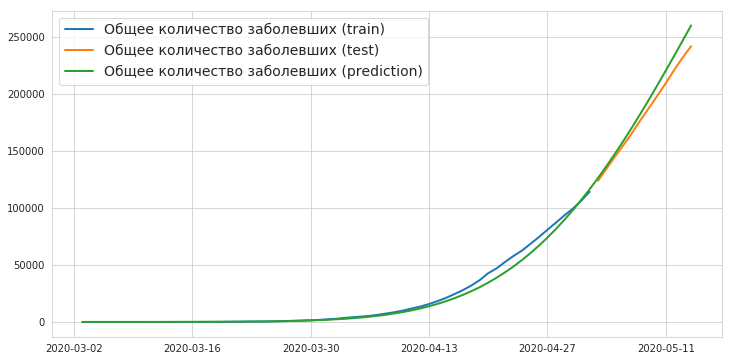

In [59]:
eval_ml_model(log_poly_ru_new_cases_model, X, ru_data.total_cases.values, 'Общее количество заболевших',
             pred_transform=lambda x: np.cumsum(np.exp(x)-1))

### Теперь получим апостериорное распределение параметров модели

In [60]:
prior_mu, prior_cov = np.array([0, 0, 0]), np.eye(3) * 3

prior_dist = multivariate_normal(mean=prior_mu, cov=prior_cov)

In [61]:
log_poly_ru_new_cases_variance = get_variance(log_poly_ru_new_cases_model, X, log_ru_new_cases.values)
log_poly_ru_new_cases_variance

0.5715886537621683

In [62]:
log_poly_ru_new_cases_mu_posterior, log_poly_ru_new_cases_cov_posterior = bayesian_update(prior_mu, prior_cov,
                    X[:train_days+1], y[:train_days+1],
                    log_poly_ru_new_cases_variance)

In [63]:
log_poly_ru_new_cases_mu_posterior

array([-0.53846778,  0.27199566, -0.00183852])

In [64]:
log_poly_ru_new_cases_cov_posterior

array([[ 7.69984534e-02, -5.09001703e-03,  7.01089782e-05],
       [-5.09001703e-03,  4.60419933e-04, -7.19560546e-06],
       [ 7.01089782e-05, -7.19560546e-06,  1.20281161e-07]])

In [65]:
log_poly_ru_new_cases_posterior = multivariate_normal(mean=log_poly_ru_new_cases_mu_posterior,
                                                      cov=log_poly_ru_new_cases_cov_posterior)

In [66]:
def plot_sample_sigmoids(dist, x_max=100, y_max=6e5,
                         n=500, n_params=5, min_date=min_date, plot_samples=True,
                        fig=None, ax=None, figsize=figsize):
    fig = fig or plt.figure(figsize=figsize)
    ax = ax or fig.add_subplot(111)
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)
    x_range = np.arange(1, x_max, 1)
    dates = days_to_dates(x_range, min_date=min_date)
    y_values = np.empty((n, len(x_range)))
    for i, (w0, w1, w2) in enumerate(dist.rvs(n)):
        if n_params is None or i < n_params:
            print_model_coefs(coefs=[w0, w1, w2])
        y = np.cumsum(np.exp(w0 + w1 * x_range + w2 * (x_range ** 2)) - 1)
        y_values[i] = y
        if plot_samples:
            ax.plot(dates, y, 'k-', lw=0.25, alpha=0.3)
    plot_pred_std(dates, y_values, fig, ax)
    plt.ylim((0, y_max))
    return fig, ax

Примеры параметров и сигмоид из апостериорного распределения для общего числа случаев
Коэффициенты модели [w0;...;w2]: [-0.83788  0.29804 -0.00209]
Коэффициенты модели [w0;...;w2]: [-0.49817  0.26995 -0.00191]
Коэффициенты модели [w0;...;w2]: [-0.79424  0.2901  -0.00209]
Коэффициенты модели [w0;...;w2]: [ 0.03704  0.23579 -0.00138]
Коэффициенты модели [w0;...;w2]: [-0.17785  0.2484  -0.00152]


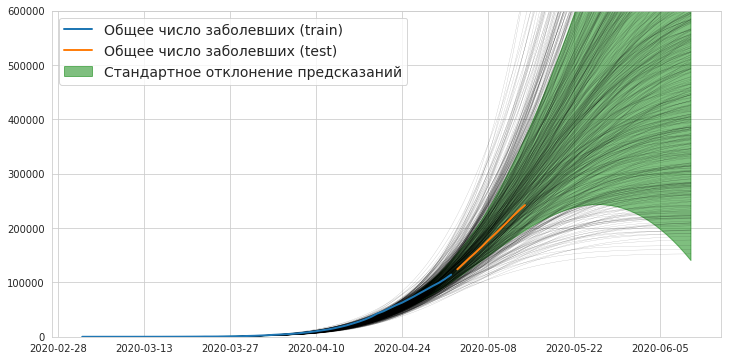

In [67]:
print('Примеры параметров и сигмоид из апостериорного распределения для общего числа случаев')
fig, ax = plot_sample_sigmoids(log_poly_ru_new_cases_posterior)
plot_series(ru_data.day.values[:train_days+1], ru_data.total_cases.values[:train_days+1]
            , f'Общее число заболевших (train)', fig, ax)
plot_series(ru_data.day.values[train_days+1:], ru_data.total_cases.values[train_days+1:]
            , f'Общее число заболевших (test)', fig, ax);

### Найдём предсказательное распределение на общее число случаев в России
В качестве общего количества случаев возьмём число случаев через 2 года от начала

In [68]:
last_date = '2022-03-03'
last_day = get_day_number(last_date)
last_day

731

In [69]:
def generate_sigmoid_predictions(distribution, last_day, n=10000):
    pred_values = []
    x_range = np.arange(1, last_day, 1)
    for w0, w1, w2 in distribution.rvs(n):
        pred_value = np.sum(np.exp(w0 + w1 * x_range + w2 * (x_range ** 2)) - 1)
        pred_values.append(pred_value)
    return pd.Series(pred_values)

In [70]:
def describe_sigmoid_predictions(pred_values, date, truncate=6e6):
    print(f'Ожидаемое (медиана по предсказаниям) число заболевших: {np.median(pred_values):.0f}')
    optimistic_value, pessimistic_value = pred_values.quantile(0.1), pred_values.quantile(0.9)
    print(f'Оптимистичная оценка (10-й процентиль): {optimistic_value:.0f}')
    print(f'Пессимистичная оценка (90-й процентиль): {pessimistic_value:.0f}')
    print('Эмпирическое распределение:')
    truncated_pred_values = pred_values[pred_values <= truncate]
    truncated_pred_values.hist(density=True, bins=100);

In [71]:
pred_values = generate_sigmoid_predictions(log_poly_ru_new_cases_posterior, last_day)

Ожидаемое (медиана по предсказаниям) число заболевших: 561583
Оптимистичная оценка (10-й процентиль): 272781
Пессимистичная оценка (90-й процентиль): 1829074
Эмпирическое распределение:


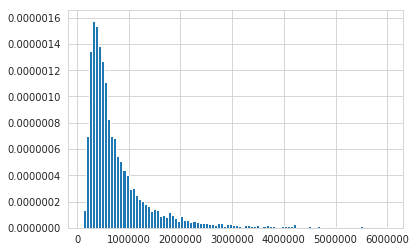

In [72]:
describe_sigmoid_predictions(pred_values, date)

# Модели для разных стран

In [73]:
min_data_size = 70
min_total_cases = 10000
country_data = {}

for country_name, country_df in data.groupby('location'):
    country_df = country_df[country_df.total_cases > 15].reset_index(drop=True).copy()
    if len(country_df) < min_data_size or country_df.total_cases.max() < min_total_cases:
        continue
    country_min_date = country_df.date.min()
    country_data[country_name] = {
        'min_date': country_min_date,
        'data': country_df
    }

In [74]:
predict_days = 180

In [75]:
def get_map_total_prediction(mu_posterior, predict_days):
    x = np.c_[np.arange(predict_days), np.arange(predict_days)**2]
    log_pred = mu_posterior[0] + mu_posterior[1]*x[:,0] + mu_posterior[2]*x[:,1]
    return np.cumsum(np.exp(log_pred)-1, axis=0)

In [82]:
def plot_country_total(country_name, country_df, posterior, country_min_date, predict_days, fig=None, ax=None):
    model_pred = get_map_total_prediction(posterior.mean, predict_days)
    y_max = max(min(1.1 * model_pred.max(), 5 * country_df.total_cases.max()), 1.1 * country_df.total_cases.max())
    fig, ax = plot_sample_sigmoids(posterior, min_date=country_min_date,
                                            x_max=predict_days, y_max=y_max,
                                            n_params=0, plot_samples=False,
                                            fig=fig, ax=ax, figsize=(8, 4))
    plot_series(country_df.day.values, country_df.total_cases.values
                , f'Реальное общее число заболевших', fig, ax, min_date=country_min_date)
    plot_series(country_x[:, 0], model_pred, f'Общее число заболевших (MAP-prediction)', fig, ax, min_date=country_min_date)
    ax.set_title(country_name, fontsize=16)
    ax.legend()

In [83]:
def get_map_new_prediction(mu_posterior, predict_days):
    x = np.c_[np.arange(predict_days), np.arange(predict_days)**2]
    log_pred = mu_posterior[0] + mu_posterior[1]*x[:,0] + mu_posterior[2]*x[:,1]
    return np.exp(log_pred)-1

In [84]:
def plot_country_new(country_name, country_df, posterior, country_min_date, predict_days, fig=None, ax=None):
    model_pred = get_map_new_prediction(posterior.mean, predict_days)
    y_max = max(min(1.1 * model_pred.max(), 5 * country_df.new_cases.max()), 1.1 * country_df.new_cases.max())
    ax.set_ylim((0, y_max))
    plot_series(country_df.day.values, country_df.new_cases.values
                , f'Реальное число новых заболевших', fig, ax, min_date=country_min_date)
    plot_series(country_x[:, 0], model_pred, f'Число новых заболевших (MAP-prediction)', fig, ax, min_date=country_min_date)
    ax.set_title(country_name, fontsize=16)
    ax.legend()

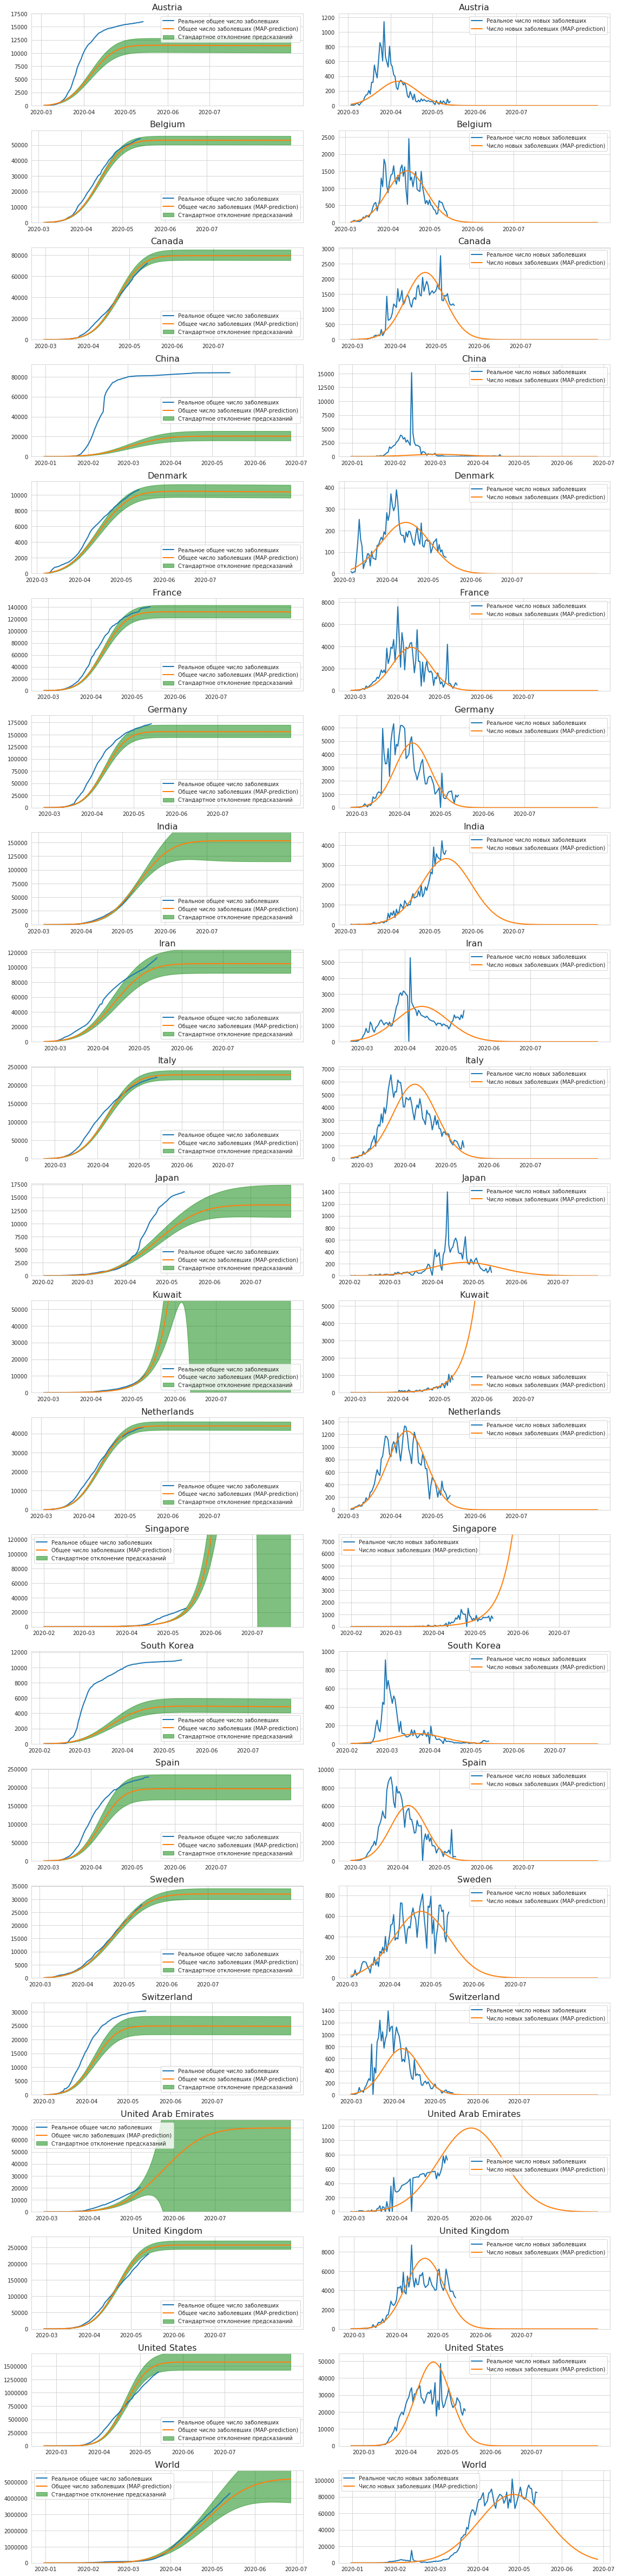

In [85]:
fig = plt.figure(figsize=(8 * 2, 6 * len(country_data)))
country_weights = []

for i, (country_name, country) in enumerate(country_data.items()):
    country_min_date, country_df = country_data[country_name]['min_date'], country_data[country_name]['data']
    country_df['day'] = country_df.index
    country_df.loc[country_df.new_cases < 0, 'new_cases'] = 0
    country_x = np.c_[np.arange(predict_days), np.arange(predict_days)**2]
    country_y = np.log(country_df.new_cases + 1).values
    ml_model = linear_model.LinearRegression().fit(country_x[:len(country_y)], country_y)
    variance = get_variance(ml_model, country_x[:len(country_y)], country_y)
    prior_mu, prior_cov = np.array([0, 0, 0]), np.eye(3) * 10
    mu_posterior, cov_posterior = bayesian_update(prior_mu, prior_cov,
                    country_x[:len(country_y)], country_y,
                    variance)
    country_weights.append(mu_posterior)
    posterior = multivariate_normal(mean=mu_posterior, cov=cov_posterior)
    ax = fig.add_subplot(2*len(country_data), 2, 2*i+1)
    plot_country_total(country_name, country_df, posterior, country_min_date, predict_days, fig=fig, ax=ax)
    ax = fig.add_subplot(2*len(country_data), 2, 2*i+2)
    plot_country_new(country_name, country_df, posterior, country_min_date, predict_days, fig=fig, ax=ax)
plt.tight_layout()

## Попробуем кластеризовать обученные параметры

In [86]:
country_weights = np.array(country_weights)
normalized_country_weights = (country_weights - np.mean(country_weights, axis=0)) / np.std(country_weights, axis=0)

In [96]:
from sklearn.decomposition import PCA
pca_weights = PCA(n_components=2, random_state=42).fit_transform(normalized_country_weights)

In [106]:
# !pip install adjustText

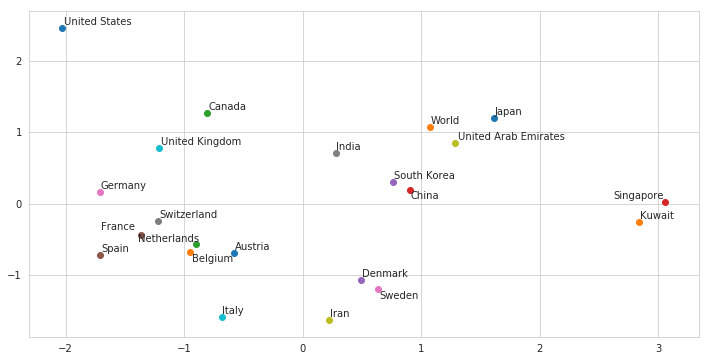

In [109]:
from adjustText import adjust_text

texts = []
fig, ax = plt.subplots(figsize=figsize)
for country_name, (x, y) in zip(country_data.keys(), pca_weights):
    ax.scatter(x, y)
    texts.append(ax.text(x, y, country_name))
adjust_text(texts);

Сингапур и Кувейт: для этих стран модель выучила положительный коэффициент перед квадратичным членом.
Левее нуля расположились западные страны, в их моделях предполагается довольно быстрый рост новых случаев с таким же быстрым спадом. Правее - восточные страны, мир в целом, а также Дания и Швеция. Для них характерна модель в виде пологого "колокола", то есть довольно медленного роста и последующего спада количества новых случаев. 